In [ ]:
#Project：华盛顿自行车租赁情况分析

Step1：load Data

In [2]:
import os
import pandas as pd #读取数据到DataFrame
import urllib #get data from website
import tempfile #create a temp file system
import shutil #file operation
import zipfile #unzip file

In [11]:
#Data Source:https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset
# 文件地址
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"
# 下载文件名
file_name = "Bike-Sharing-Dataset.zip"

# 下载文件
urllib.request.urlretrieve(url, file_name)
print("Download complete.")

# 解压文件
print("Extracting files...")
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(".")
print("Extraction complete.")

# 删除zip文件
os.remove(file_name)
print("Zip file removed.")

Download complete.
Extracting files...
Extraction complete.
Zip file removed.


In [13]:
daily_data = pd.read_csv('day.csv') #read data csv file
daily_data['dteday'] = pd.to_datetime(daily_data['dteday']) #transfer date from string to date format
drop_list = ['instant','season','yr','mnth','holiday','workingday','weathersit','atemp','hum'] 
daily_data.drop(drop_list, axis=1, inplace=True)

In [14]:
daily_data.head()

,dteday,weekday,temp,windspeed,casual,registered,cnt
0,2011-01-01,6,0.344167,0.160446,331,654,985
1,2011-01-02,0,0.363478,0.248539,131,670,801
2,2011-01-03,1,0.196364,0.248309,120,1229,1349
3,2011-01-04,2,0.200000,0.160296,108,1454,1562
4,2011-01-05,3,0.226957,0.186900,82,1518,1600


Step2:配置参数

In [16]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [18]:
#Set default setting
matplotlib.rc('figure',figsize=[14,7])  #rc: resource configuration
matplotlib.rc('font', size=14) #Font configuration
matplotlib.rc('axes',grid=False) #ignore the grid
matplotlib.rc('axes',facecolor='white') #backgroud color:white

Step3:关联分析

scatter plot

In [19]:
def scatterplot(x_data, y_data, x_label, y_label,title, ax = None):
    if ax:
        pass
    else:
        fig, ax = plt.subplots()
    
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Set the data point's size, color, and visibility
    ax.scatter(x_data, y_data, s=10,color='#539caf',alpha=0.75)
    
    # Set title and legend
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

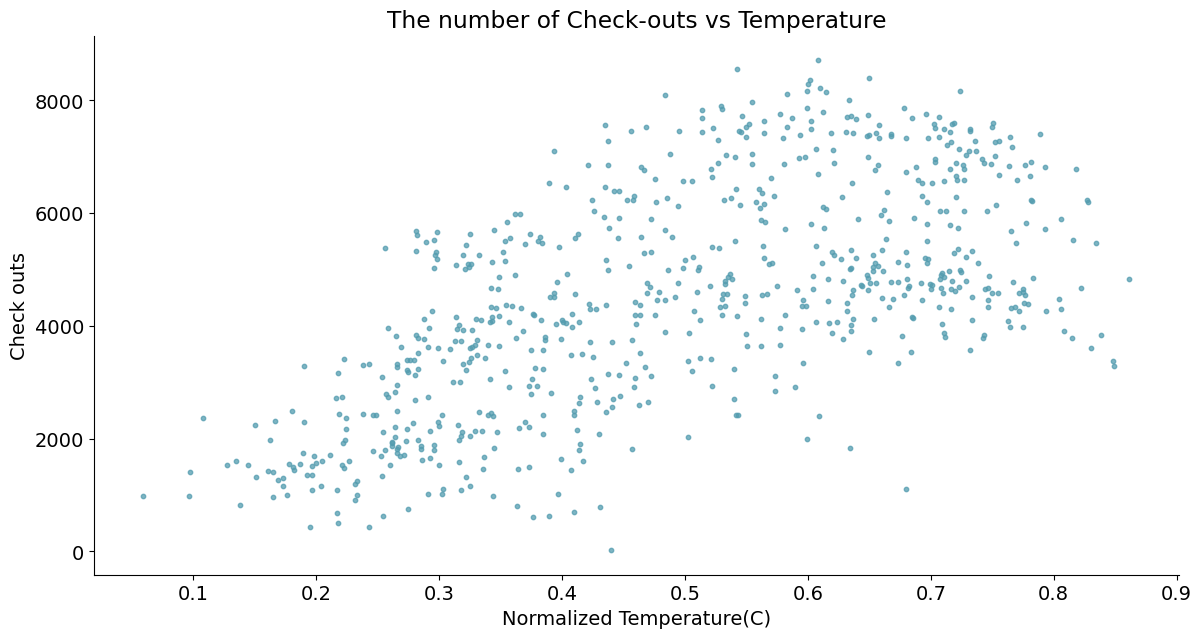

In [20]:
# Draw the line chart
scatterplot(x_data = daily_data['temp'],
            x_label = 'Normalized Temperature(C)',
            y_data = daily_data['cnt'],
            y_label = 'Check outs',
            title = 'The number of Check-outs vs Temperature')

拟合变量关系

In [23]:
# 线性回归
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
x = sm.add_constant(daily_data['temp']) #线性回归增加常数项
y = daily_data['cnt']
regr = sm.OLS(y, x) #ordinary least square model
res = regr.fit()

# 从模型获得拟合数据
st, data, ss2 = summary_table(res, alpha=0.05) #置信水平95%，st数据汇总，data数据详情，ss2数据列名
fitted_values = data[:,2]

In [27]:
x.head()
#type(regr)
#st

,const,temp
0,1.0,0.344167
1,1.0,0.363478
2,1.0,0.196364
3,1.0,0.200000
4,1.0,0.226957


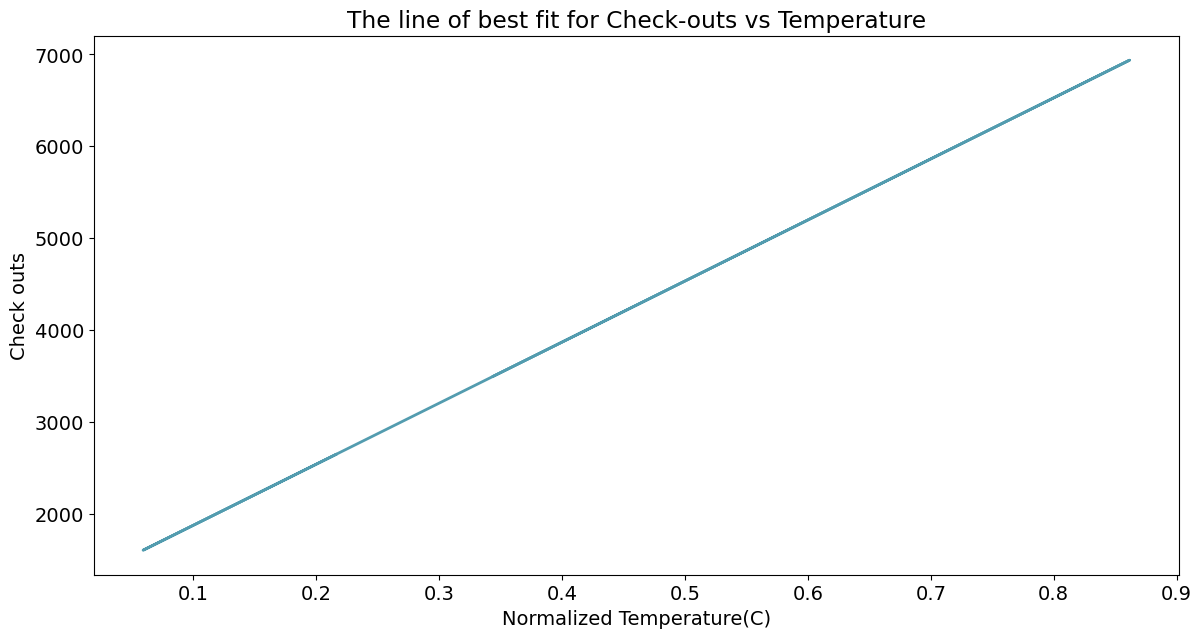

In [28]:
def lineplot(x_data, y_data, x_label, y_label, title):
    _, ax = plt.subplots()
    
    #绘制拟合曲线
    ax.plot(x_data, y_data, lw=2, color='#539caf', alpha=1)
    
    #Add title and legend
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

#调用绘制函数
lineplot(x_data = daily_data['temp'],
         y_data = fitted_values,
         x_label = 'Normalized Temperature(C)',
         y_label = 'Check outs',
         title = 'The line of best fit for Check-outs vs Temperature')

In [29]:
# 绘制带置信区间的趋势线

# 获得置信区间的上下分界
predict_mean_ci_low, predict_mean_ci_high = data[:,4:6].T

# 创建置信区间的DataFrame
CI_df = pd.DataFrame(columns = ['x_data','low_ci','high_ci'])
CI_df['x_data'] = daily_data['temp']
CI_df['low_ci'] = predict_mean_ci_low
CI_df['high_ci'] = predict_mean_ci_high
CI_df.sort_values('x_data',inplace=True) #Sorted by date

#绘制置信区间
def lineplot(x_data, y_data, sorted_x, low_ci, high_ci, x_label, y_label, title):
    _, ax = plt.subplots()
    
    # 绘制趋势曲线
    ax.plot(x_data, y_data, lw=1, color='#539caf', alpha=1, label='Fit')
    # 绘制置信区间，顺序填充
    ax.fill_between(sorted_x, low_ci, high_ci, color='#539caf', alpha=0.4, label='95% CI')
    # Add Title and legend
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    #Display legend
    ax.legend(loc='best')
    return ax


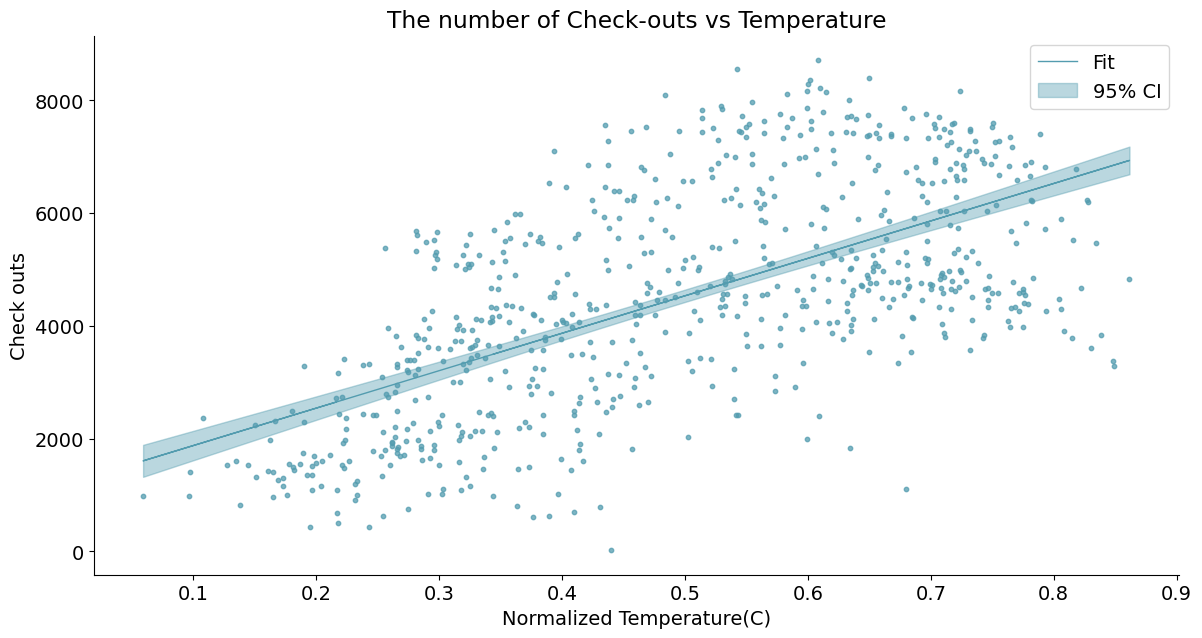

In [32]:
#Call the function to create plot
ax = lineplot(x_data = daily_data['temp'],
              y_data = fitted_values,
              sorted_x = CI_df['x_data'],
              low_ci = CI_df['low_ci'],
              high_ci = CI_df['high_ci'],
              x_label = 'Normalized Temperature(C)',
              y_label = 'Check outs',
              title = 'The line of best fit for Check-outs vs Temperature')

#叠加上绘制的Scatter plot
scatterplot(x_data = daily_data['temp'],
            y_data = daily_data['cnt'],
            x_label = 'Normalized Temperature(C)',
            y_label = 'Check outs',
            title = 'The number of Check-outs vs Temperature',
            ax = ax)

双坐标曲线图

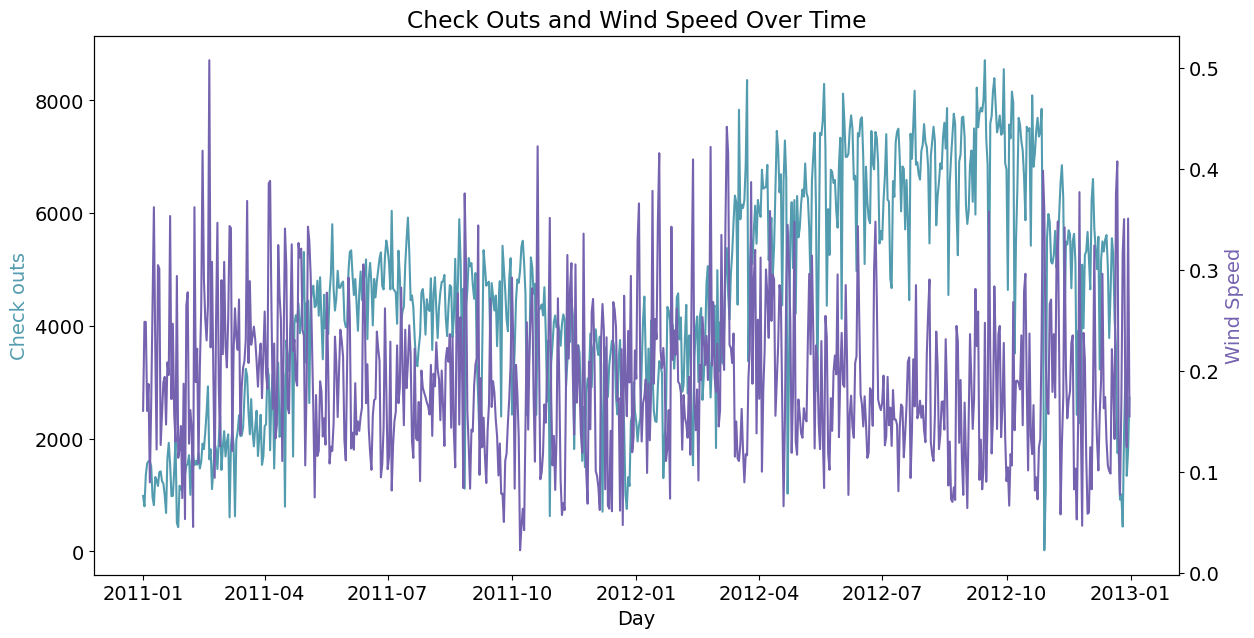

In [34]:
# 双纵坐标绘图函数
def lineplot2y(x_data, x_label, 
               y1_data, y1_color, y1_label,
               y2_data, y2_color, y2_label, title):
    _, ax1 = plt.subplots()
    ax1.plot(x_data, y1_data, color = y1_color)
    #添加标题和坐标说明
    ax1.set_ylabel(y1_label, color = y1_color)
    ax1.set_xlabel(x_label)
    ax1.set_title(title)
    
    ax2 = ax1.twinx() #两个绘图对象共享横坐标轴
    ax2.plot(x_data, y2_data, color = y2_color)
    ax2.set_ylabel(y2_label, color = y2_color)
    # 右侧坐标轴可见
    ax2.spines['right'].set_visible(True)

# 调用绘制函数
lineplot2y(x_data = daily_data['dteday'],
           x_label = 'Day',
           y1_data = daily_data['cnt'],
           y1_color = '#539caf',
           y1_label = 'Check outs',
           y2_data = daily_data['windspeed'],
           y2_color = '#7663b0',
           y2_label = 'Wind Speed',
           title = 'Check Outs and Wind Speed Over Time')

Step 4: 分布分析

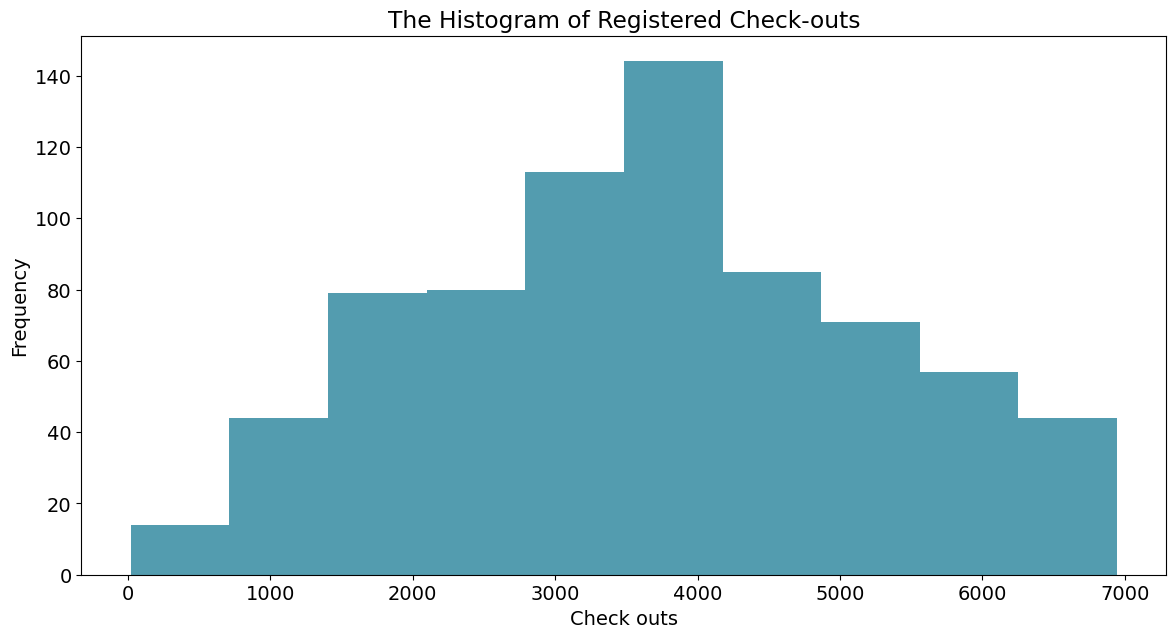

In [35]:
def histgram(data, x_label, y_label, title):
    _, ax = plt.subplots()
    res = ax.hist(data, color = '#539caf', bins=10)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return res

# 绘图函数调用
res = histgram(daily_data['registered'],
               x_label = 'Check outs',
               y_label = 'Frequency',
               title = 'The Histogram of Registered Check-outs')

In [36]:
res[0]

array([ 14.,  44.,  79.,  80., 113., 144.,  85.,  71.,  57.,  44.])

In [37]:
res[1]

array([  20. ,  712.6, 1405.2, 2097.8, 2790.4, 3483. , 4175.6, 4868.2,
       5560.8, 6253.4, 6946. ])

堆叠直方图

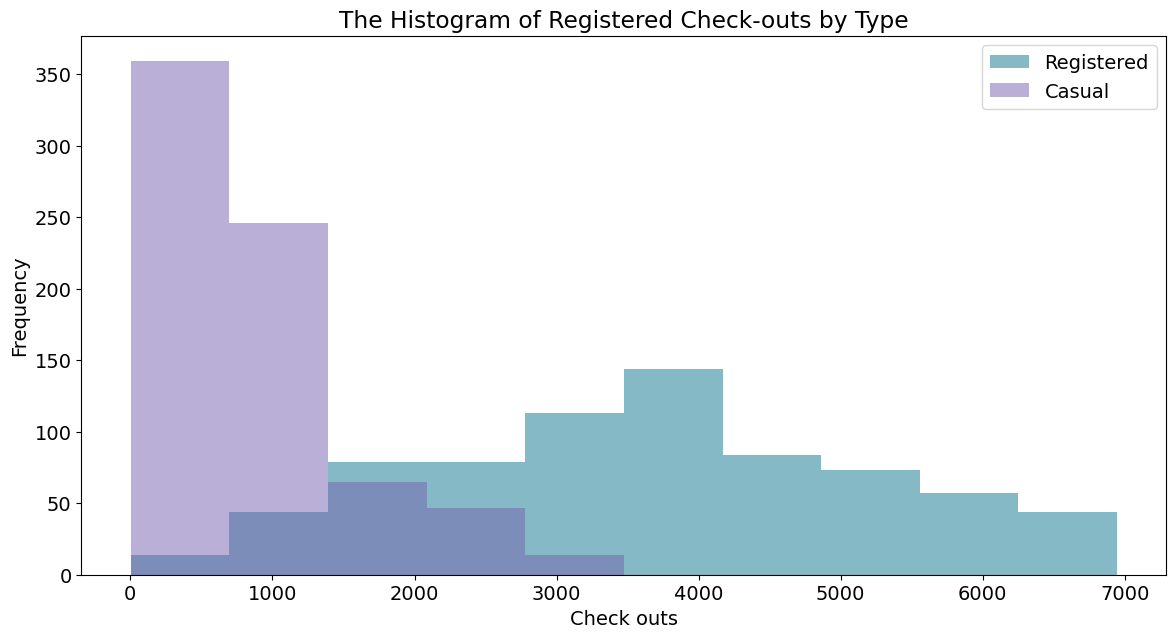

In [40]:
def overlaid_histogram(data1, data1_name, data1_color, data2, data2_name, data2_color, x_label, y_label, title):
    #归一化数据区间，对齐两个直方图的bins
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins
    bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)  #生成直方图bins区间
    # Create the plot
    _, ax = plt.subplots()
    ax.hist(data1, bins=bins, color=data1_color, alpha=0.7, label=data1_name)
    ax.hist(data2, bins=bins, color=data2_color, alpha=0.5, label=data2_name)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc = 'best')

# call the function to create plot
overlaid_histogram(daily_data['registered'],
                   data1_name='Registered',
                   data1_color='#539caf',
                   data2=daily_data['casual'],
                   data2_name='Casual',
                   data2_color='#7663b0',
                   x_label = 'Check outs',
                   y_label = 'Frequency',
                   title = 'The Histogram of Registered Check-outs by Type')

密度图

In [41]:
from scipy.stats import gaussian_kde
data = daily_data['windspeed']
density_est = gaussian_kde(data) 
# 控制平滑程度，数字越大，越平滑
density_est.covariance_factor = lambda: 0.3

density_est._compute_covariance()
x_data = np.arange(min(data), max(data), 200)

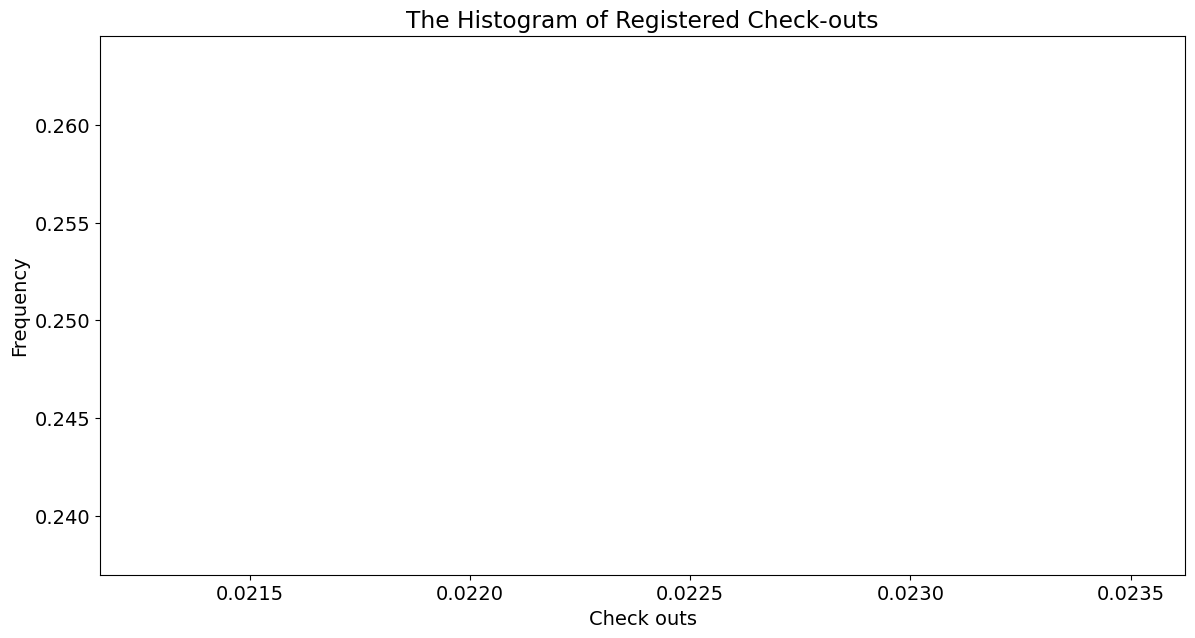

In [44]:
# 绘制密度图预测曲线
def densityplot(x_data, density_est, x_label, y_label, title):
    _, ax = plt.subplots()
    ax.plot(x_data, density_est(x_data), color='#539caf', lw=2)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
#调用绘图函数
densityplot(
    x_data=x_data,
    density_est=density_est,
    x_label = 'Check outs',
    y_label = 'Frequency',
    title = 'The Histogram of Registered Check-outs'
)

In [45]:
type(density_est)

scipy.stats.kde.gaussian_kde

Step5: 组间分析

柱状图

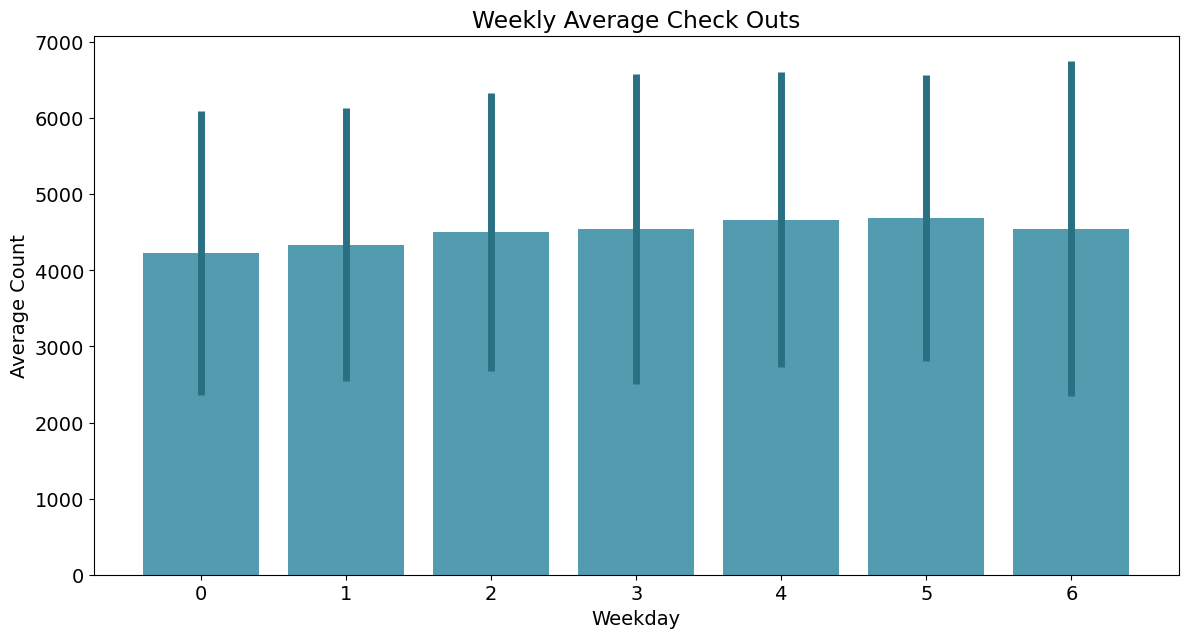

In [48]:
# Calculate the mean and standard deviation of 'cnt' grouped by 'weekday'
mean_total_co_day = daily_data[['weekday', 'cnt']].groupby('weekday').agg(['mean', 'std'])

# Rename columns for clarity
mean_total_co_day.columns = ['mean', 'std']  # Simplify the MultiIndex to regular columns

# Define a function to create a bar plot
def barplot(x_data, y_data, x_label, y_label, title, error_data):
    _, ax = plt.subplots()
    # Create the bar plot
    ax.bar(x_data, y_data, color='#539caf', align='center')
    # Add error bars to represent the standard deviation
    ax.errorbar(x_data, y_data, yerr=error_data, color='#297083', ls='None', lw=5)  # ls: linestyle, lw: linewidth
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

# Example call to the function, assuming 'mean_total_co_day' is correctly calculated
x_data = mean_total_co_day.index  # weekdays as x-axis data
y_data = mean_total_co_day['mean']  # means as y-axis data
error_data = mean_total_co_day['std']  # standard deviations as error bar lengths

# Call the plotting function
barplot(x_data=x_data, y_data=y_data, error_data=error_data, x_label='Weekday', y_label='Average Count', title='Weekly Average Check Outs')

In [49]:
mean_total_co_day.columns
#daily_data[['weekday','cnt']].groupby('weekday').agg(np.mean,np.std)

Index(['mean', 'std'], dtype='object')

堆积柱状图

In [50]:
mean_by_reg_co_day =daily_data[['weekday','registered','casual']].groupby('weekday').mean()
mean_by_reg_co_day

,registered,casual
weekday,,
0,2890.533333,1338.295238
1,3663.990476,674.133333
2,3954.480769,556.182692
3,3997.394231,551.144231
4,4076.298077,590.961538
5,3938.000000,752.288462
6,3085.285714,1465.257143


In [51]:
#按天统计注册和偶然使用的情况
mean_by_reg_co_day =daily_data[['weekday','registered','casual']].groupby('weekday').mean()
#按天统计占比
mean_by_reg_co_day['total'] = mean_by_reg_co_day['registered'] + mean_by_reg_co_day['casual']
mean_by_reg_co_day['reg_prop'] = mean_by_reg_co_day['registered'] / mean_by_reg_co_day['total']
mean_by_reg_co_day['casual_prop'] = mean_by_reg_co_day['casual'] / mean_by_reg_co_day['total']

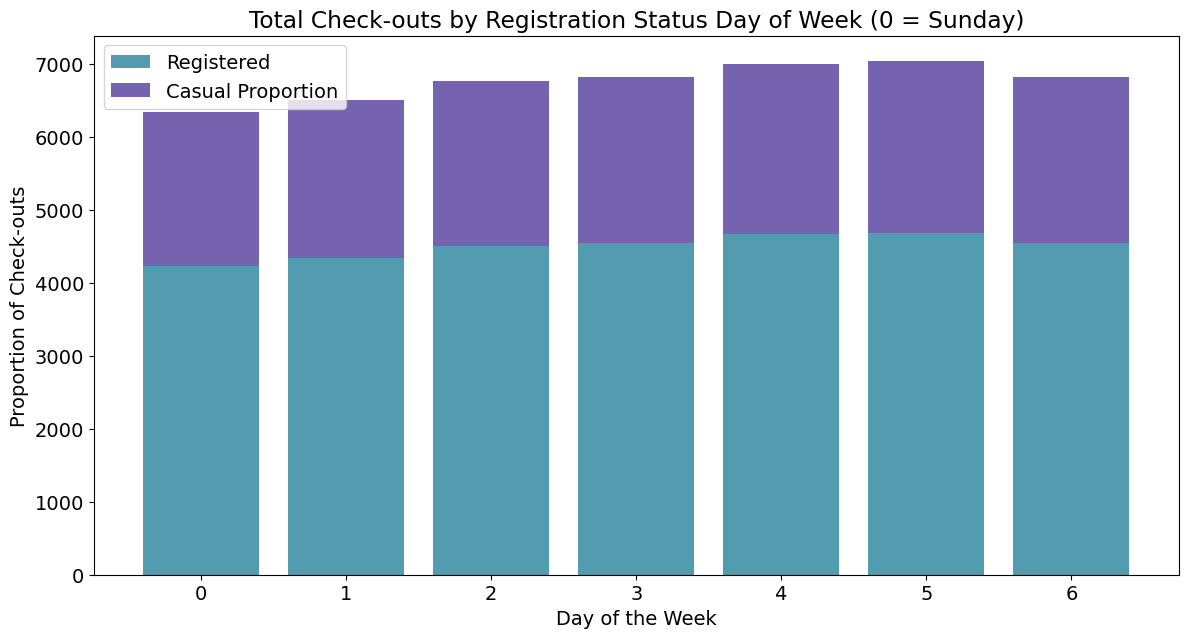

In [66]:
# Assuming 'casual_prop' needs to be calculated and added to the DataFrame
mean_total_co_day['casual_prop'] = mean_total_co_day['mean'] * 0.5  # This is an example calculation

# Corrected function call with proper y_data_names as a list of strings
def stacked_barplot(x_data, y_data_list, y_data_names, color, x_label, y_label, title):
    _, ax = plt.subplots()
    # 绘制堆积柱状图
    bottoms = np.zeros_like(y_data_list[0])
    for i, y_data in enumerate(y_data_list):
        ax.bar(x_data, y_data, color=color[i], bottom=bottoms, align='center', label=y_data_names[i])
        bottoms += y_data  # Update the bottoms array to stack the bars
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc='best')

# Call the plotting function
stacked_barplot(x_data=mean_total_co_day.index.values,
                y_data_list=[mean_total_co_day['mean'], mean_total_co_day['casual_prop']],
                y_data_names=['Registered', 'Casual Proportion'],
                color=['#539caf', '#7663b0'],
                x_label='Day of the Week',
                y_label='Proportion of Check-outs',
                title='Total Check-outs by Registration Status Day of Week (0 = Sunday)')

In [ ]:
分组柱状图

In [68]:
# Compute the mean values of 'registered' and 'casual' grouped by 'weekday'
mean_total_co_day = daily_data.groupby('weekday')[['registered', 'casual']].mean()
print(mean_total_co_day)

          registered       casual
weekday                          
0        2890.533333  1338.295238
1        3663.990476   674.133333
2        3954.480769   556.182692
3        3997.394231   551.144231
4        4076.298077   590.961538
5        3938.000000   752.288462
6        3085.285714  1465.257143


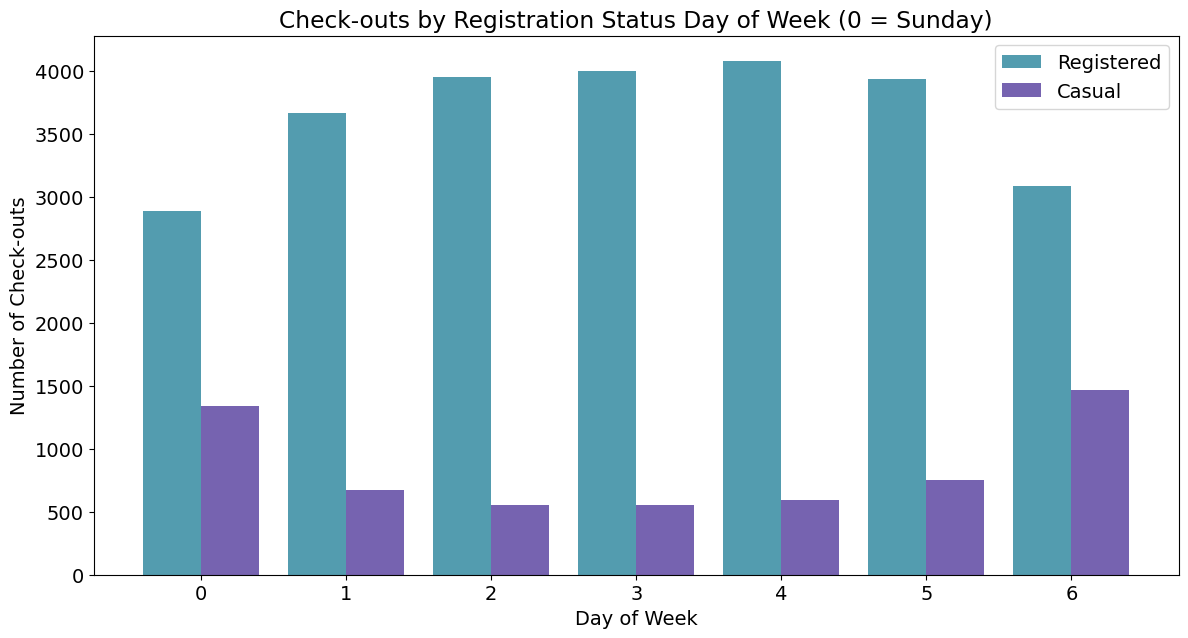

In [69]:
# Define your grouped bar plot function
def grouped_bar_plot(x_data, y_data_list, y_data_names, colors, x_label, y_label, title):
    _, ax = plt.subplots()
    total_width = 0.8
    ind_width = total_width / len(y_data_list)
    alteration = np.linspace(-total_width/2 + ind_width/2, total_width/2 - ind_width/2, len(y_data_list))

    for i, y_data in enumerate(y_data_list):
        ax.bar(x_data + alteration[i], y_data, color=colors[i], label=y_data_names[i], width=ind_width)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc='best')

# Call the plotting function
grouped_bar_plot(x_data=mean_total_co_day.index,  # x_data using index from groupby
                 y_data_list=[mean_total_co_day['registered'], mean_total_co_day['casual']],
                 y_data_names=['Registered', 'Casual'],
                 colors=['#539caf', '#7663b0'],
                 x_label='Day of Week',
                 y_label='Number of Check-outs',
                 title='Check-outs by Registration Status Day of Week (0 = Sunday)')

In [65]:
print(daily_data.columns)

Index(['dteday', 'weekday', 'temp', 'windspeed', 'casual', 'registered',
       'cnt'],
      dtype='object')


In [ ]:
%%sql


box plot

In [ ]:
data.hist()

In [70]:
#指定分类依据
days = np.unique(daily_data['weekday'])
bp_data = []
for day in days:
    bp_data.append(daily_data[daily_data['weekday'] == day]['cnt'].values)

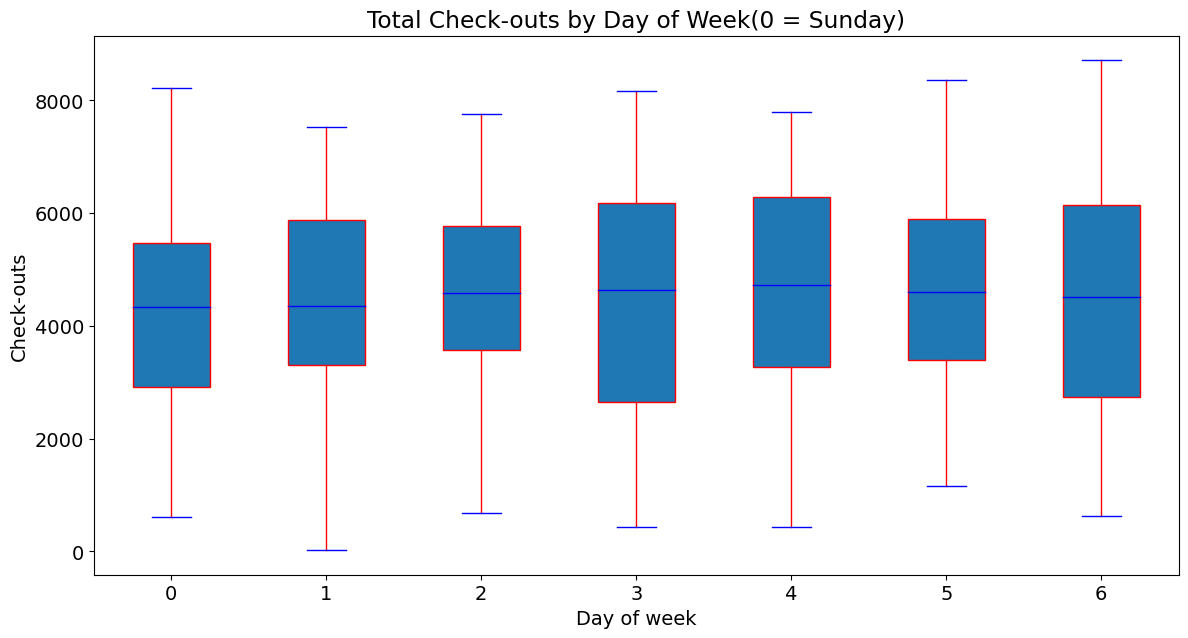

In [71]:
#定义绘图函数
def boxplot(x_data, y_data, base_color, median_color, x_label, y_label, title):
    _, ax = plt.subplots()
    
    #设置样式
    ax.boxplot(y_data,
               patch_artist=True,
               medianprops=dict(color=base_color),
               boxprops=dict(color=median_color),
               whiskerprops=dict(color=median_color),
               capprops=dict(color=base_color),
               )
    #箱型图与x_data保持一致
    ax.set_xticklabels(x_data)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

#调用绘图函数
boxplot(
    x_data=days,
    y_data=bp_data,
    base_color='b',
    median_color='r',
    x_label='Day of week',
    y_label='Check-outs',
    title='Total Check-outs by Day of Week(0 = Sunday)'
)